# ViT-based model using Transfer-Learning

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from datasets import load_dataset, DatasetDict, ClassLabel

from transformers import AutoImageProcessor, ViTForImageClassification

from transformers import Trainer, TrainingArguments

import evaluate

/Users/julio/Documents/PMM/Codigos/Test1/Classification-ViT/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Carga de datos

In [2]:
dataset = load_dataset('/Users/julio/Documentos-Local/data/Dataset of Mammography with Benign Malignant Breast Masses/DDSM Dataset')
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 13128
    })
})

In [3]:
dataset['train'][0]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=L size=227x227>,
 'label': 0}

### Revisión de categorías

(np.float64(-0.5), np.float64(226.5), np.float64(226.5), np.float64(-0.5))

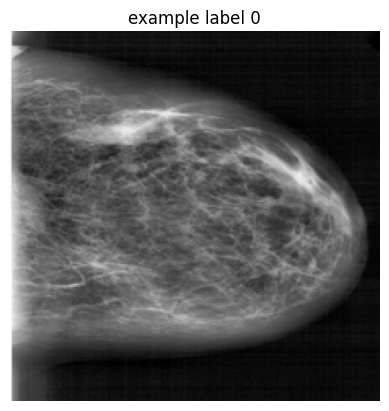

In [4]:
im = dataset['train'][0]
im = im['image']
plt.imshow(im, cmap='gray')
plt.title('example label 0')
plt.axis('off')

Label 0 -> Benign

Label 1 -> Malignant

In [5]:
label0 = dataset['train']
label0 = pd.DataFrame(label0)

In [6]:
label0[label0['label'] == 0]

,image,label
0,<PIL.PngImagePlugin.PngImageFile image mode=L ...,0
1,<PIL.PngImagePlugin.PngImageFile image mode=L ...,0
2,<PIL.PngImagePlugin.PngImageFile image mode=L ...,0
3,<PIL.PngImagePlugin.PngImageFile image mode=L ...,0
4,<PIL.PngImagePlugin.PngImageFile image mode=L ...,0
...,...,...
5965,<PIL.PngImagePlugin.PngImageFile image mode=L ...,0
5966,<PIL.PngImagePlugin.PngImageFile image mode=L ...,0
5967,<PIL.PngImagePlugin.PngImageFile image mode=L ...,0
5968,<PIL.PngImagePlugin.PngImageFile image mode=L ...,0


In [7]:
labels = dataset['train'].unique('label')
print(len(labels),labels)

2 [0, 1]


### Mapeo de etiquetas

In [9]:
# Definir las nuevas etiquetas como ClassLabel
features = dataset['train'].features.copy()
features['label'] = ClassLabel(names=['Benign', 'Malignant'])

# Aplica el cast al dataset para que acepte las etiquetas como cadenas
dataset = dataset.cast(features)

# Verifica las nuevas etiquetas
print(dataset['train'].features['label'])

# Ahora puedes mapear los ejemplos si lo necesitas
print(dataset['train'][0])

ClassLabel(names=['Benign', 'Malignant'], id=None)
{'image': <PIL.PngImagePlugin.PngImageFile image mode=L size=227x227 at 0x175158150>, 'label': 0}


In [10]:
label2id = {c:idx for idx,c in enumerate(labels)}
id2label = {idx:c for idx,c in enumerate(labels)}

## Muestra de ejemplos

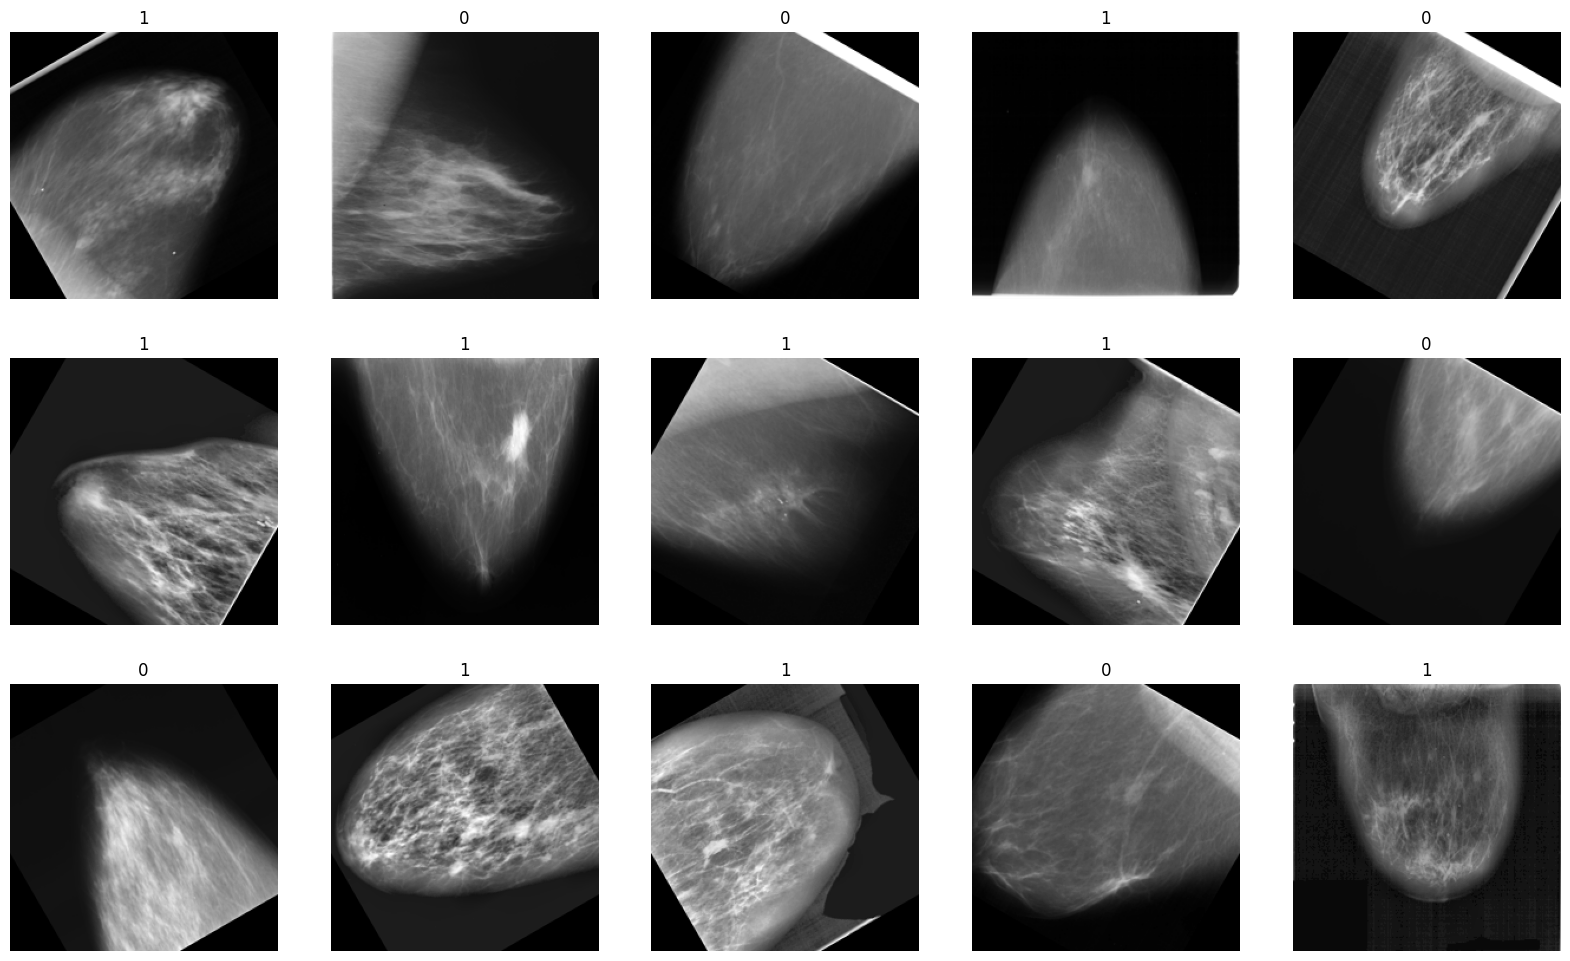

In [11]:
def show_samples(ds,rows,cols):
    samples = ds.shuffle().select(np.arange(rows*cols)) # selecting random images
    fig = plt.figure(figsize=(cols*4,rows*4))
    # plotting
    for i in range(rows*cols):
        img = samples[i]['image']
        label = samples[i]['label']
        fig.add_subplot(rows,cols,i+1)
        plt.imshow(img, cmap='gray')
        plt.title(label)
        plt.axis('off')
            
show_samples(dataset['train'],rows=3,cols=5)

## Split Dataset

In [12]:
split_dataset = dataset['train'].train_test_split(test_size=0.2)
split_dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 10502
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 2626
    })
})

In [13]:
eval_dataset = split_dataset['test'].train_test_split(test_size=0.5)
eval_dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 1313
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 1313
    })
})

In [14]:
# Recombinar los splits 

final_dataset = DatasetDict({
    'train': split_dataset['train'],
    'validation': eval_dataset['train'],
    'test': eval_dataset['test']
})

final_dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 10502
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 1313
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 1313
    })
})

## Preprocesamiento de las imágenes

In [15]:
processor = AutoImageProcessor.from_pretrained('google/vit-base-patch16-224', use_fast=True)
processor

ViTImageProcessorFast {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessorFast",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [16]:
def transforms(batch):
    batch['image'] = [x.convert('RGB') for x in batch['image']]
    inputs = processor(batch['image'],return_tensors='pt')
    inputs['labels']=[label2id[y] for y in batch['label']]
    return inputs

In [17]:
processed_dataset = final_dataset.with_transform(transforms)

### Data Collation

In [18]:
def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['labels'] for x in batch])
    }

## Métricas de evaluación

In [19]:
accuracy = evaluate.load('accuracy')
def compute_metrics(eval_preds):
    logits, labels = eval_preds
    predictions = np.argmax(logits,axis=1)
    score = accuracy.compute(predictions=predictions, references=labels)
    return score

## Carga del modelo

In [20]:
model = ViTForImageClassification.from_pretrained(
    'google/vit-base-patch16-224',
    num_labels = len(labels),
    #id2label = id2label,
    #label2id = label2id,
    ignore_mismatched_sizes = True
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Arquitectura del modelo

In [21]:
model

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

### Congelar todas las capas, menos el clasificador

In [22]:
for name,p in model.named_parameters():
    if not name.startswith('classifier'):
        p.requires_grad = False

In [23]:
num_params = sum([p.numel() for p in model.parameters()])
trainable_params = sum([p.numel() for p in model.parameters() if p.requires_grad])

print(f"{num_params = :,} | {trainable_params = :,}")

num_params = 85,800,194 | trainable_params = 1,538


## Training

In [24]:
training_args = TrainingArguments(
    output_dir="SavedModels/ViT-patch16-224_A",
    per_device_train_batch_size=16,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_steps=100,
    num_train_epochs=10,
    learning_rate=3e-4,
    save_total_limit=2,
    remove_unused_columns=False,
    push_to_hub=False,
    report_to='tensorboard',
    load_best_model_at_end=True,
)

/Users/julio/Documents/PMM/Codigos/Test1/Classification-ViT/.venv/lib/python3.11/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [25]:
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=processed_dataset["train"],
    eval_dataset=processed_dataset["validation"],
    tokenizer=processor
)

In [26]:
# Check that MPS is available
if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")

else:
    mps_device = torch.device("mps")

In [27]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.381900,0.378734,0.853008
2,0.297600,0.297149,0.890327
3,0.251300,0.259585,0.904037
4,0.227800,0.255384,0.902513
5,0.200600,0.223708,0.919269
6,0.195400,0.213798,0.918507
7,0.180200,0.204518,0.928408
8,0.172700,0.200803,0.931455
9,0.175600,0.198942,0.926885
10,0.171300,0.197948,0.927647


TrainOutput(global_step=6570, training_loss=0.2433955191114359, metrics={'train_runtime': 1883.8775, 'train_samples_per_second': 55.747, 'train_steps_per_second': 3.487, 'total_flos': 8.138208749324452e+18, 'train_loss': 0.2433955191114359, 'epoch': 10.0})

In [28]:
trainer.save_model()

## Evaluación del modelo

In [29]:
trainer.evaluate(processed_dataset['test'])

{'eval_loss': 0.1804722249507904,
 'eval_accuracy': 0.948971820258949,
 'eval_runtime': 23.3524,
 'eval_samples_per_second': 56.226,
 'eval_steps_per_second': 7.066,
 'epoch': 10.0}

### Visualización de inferencias

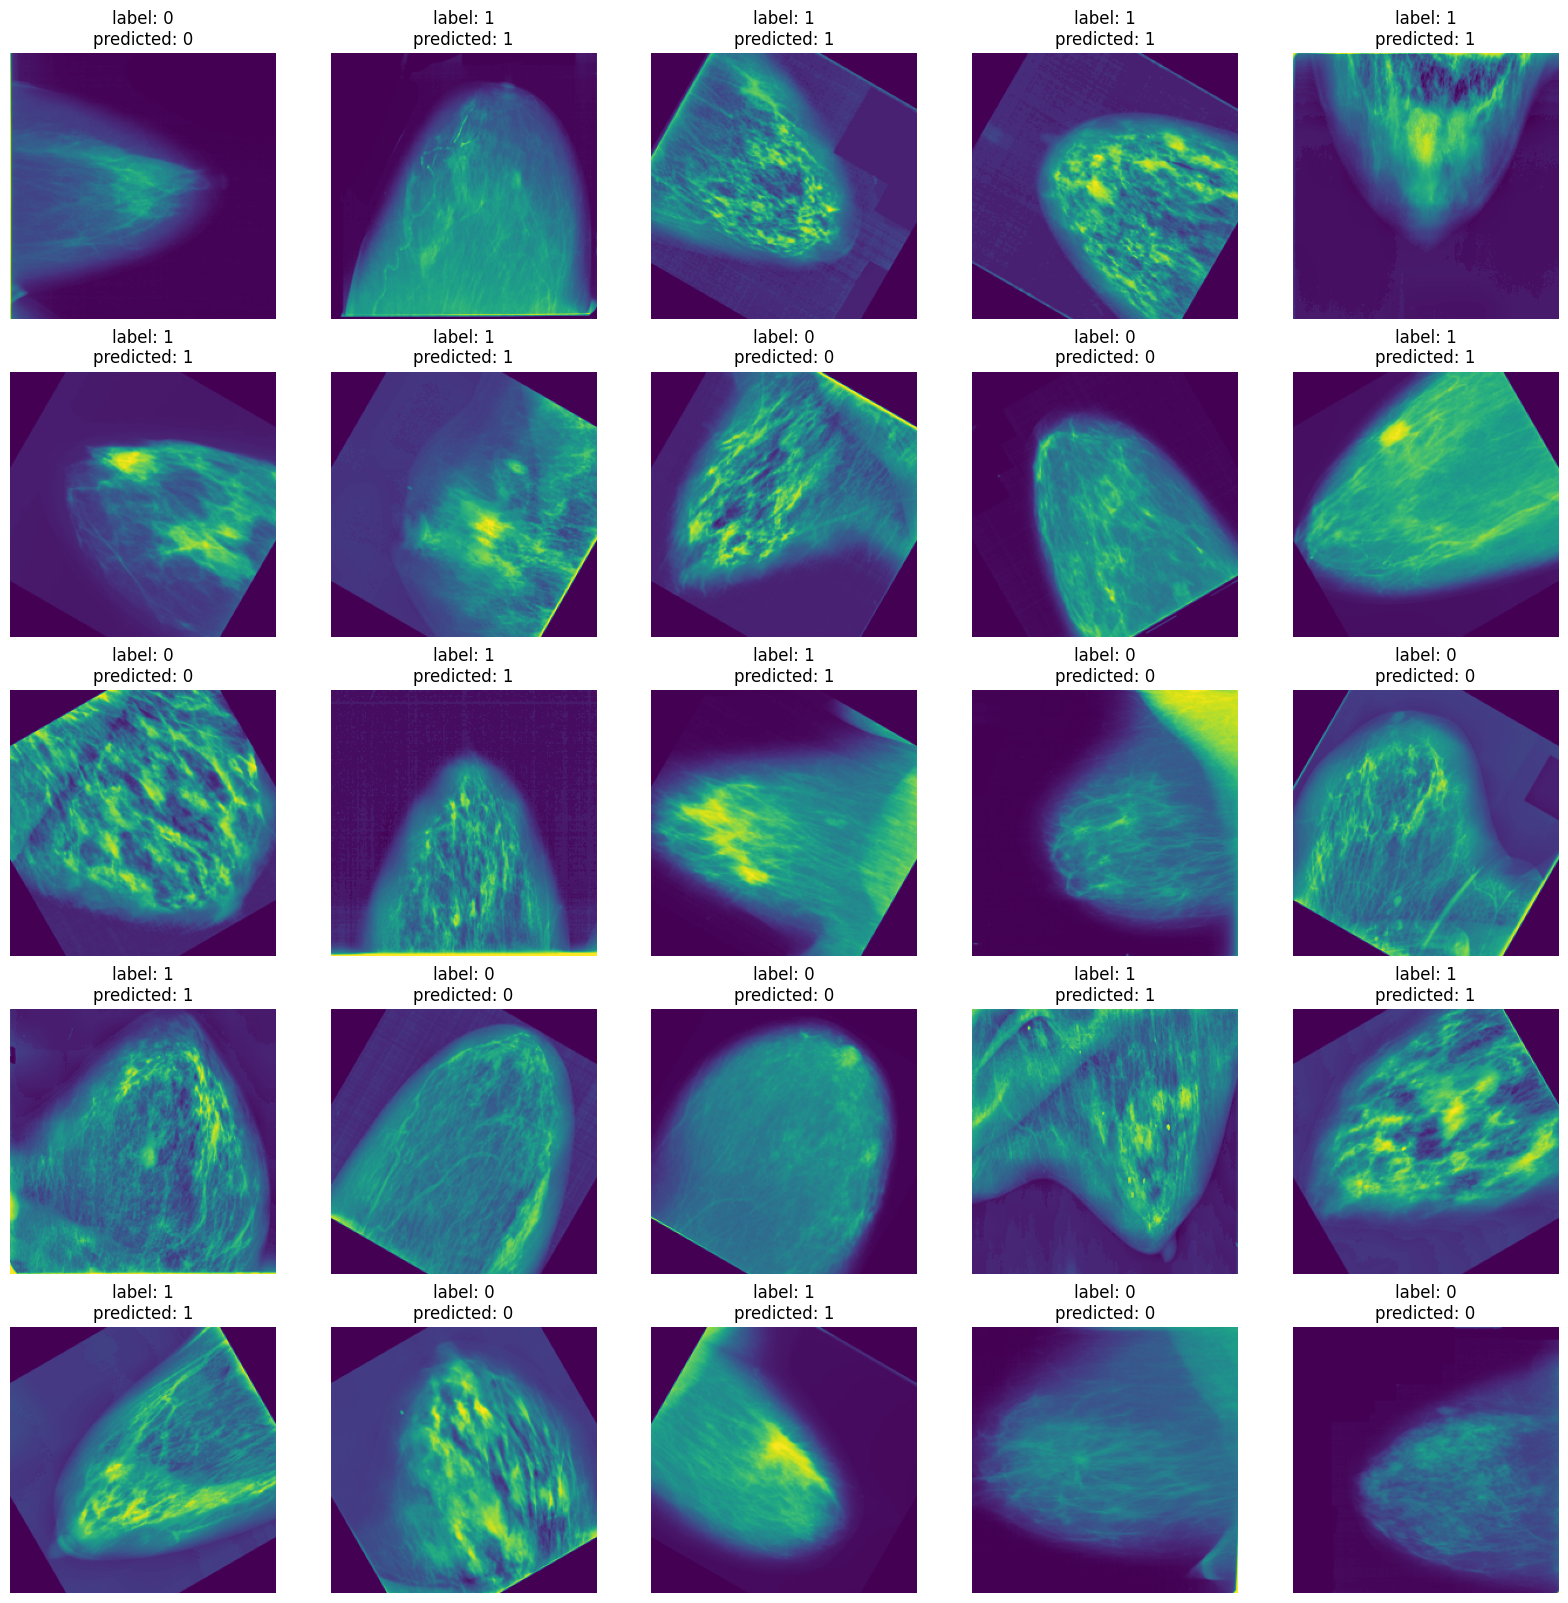

In [31]:
def show_predictions(rows,cols):
    samples = final_dataset['test'].shuffle().select(np.arange(rows*cols))
    processed_samples = samples.with_transform(transforms)
    predictions = trainer.predict(processed_samples).predictions.argmax(axis=1) # predicted labels from logits
    fig = plt.figure(figsize=(cols*4,rows*4))
    for i in range(rows*cols):
        img = samples[i]['image']
        prediction = predictions[i]
        label = f"label: {samples[i]['label']}\npredicted: {id2label[prediction]}"
        fig.add_subplot(rows,cols,i+1)
        plt.imshow(img)
        plt.title(label)
        plt.axis('off')
            
show_predictions(rows=5,cols=5)